# 用keras构建多输入-多输出-多自定义loss的模型

keras 有两种模型
* Sequential 顺序模型 
* Model 函数式模型  Model(inputs,outputs,name=None)

In [1]:
from keras import Sequential, Model
import keras.layers as KL
import keras.backend as K
import numpy as np

Using TensorFlow backend.


本文实现的模型
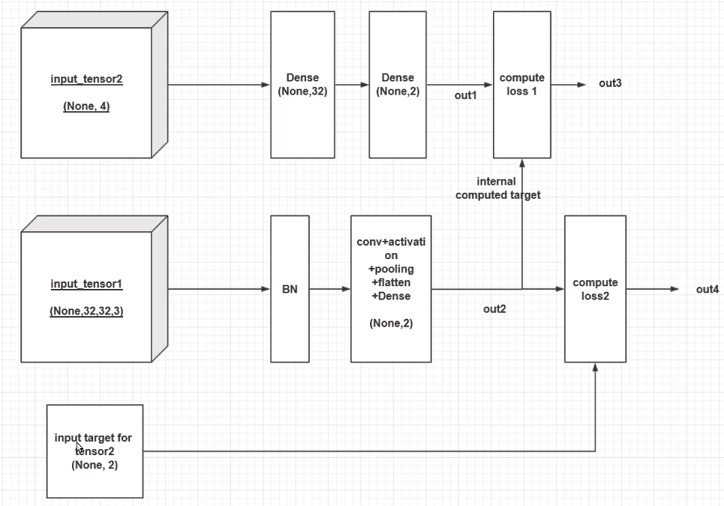

定义输入

In [2]:
input_tensor1=KL.Input((32,32,3))
input_tensor2=KL.Input((4,))
input_target=KL.Input((2,))

input_tensor1 支路

In [3]:
x=KL.BatchNormalization(axis=-1)(input_tensor1)
x=KL.Conv2D(16,(3,3),padding="same")(x)
x=KL.Activation("relu")(x)
x=KL.MaxPooling2D(2)(x)
x=KL.Conv2D(32,(3,3),padding="same")(x)
x=KL.Activation("relu")(x)
x=KL.MaxPooling2D(2)(x)   #下采样两次后 从32->8
x=KL.Flatten()(x)
x=KL.Dense(32)(x)
x=KL.Dense(2)(x)

In [4]:
out2=x   #命名问题 input_tensor1 对应 out2  见上图 

input_tensor2 支路

In [5]:
y=KL.Dense(32)(input_tensor2)
y=KL.Dense(2)(y)

In [6]:
out1=y

定义模型

In [27]:
model_temp=Model([input_tensor1,input_tensor2,input_target],[out1,out2])

可视化之前编写的模型
* 查看模型结构
* 文字方法表述

In [28]:
model_temp.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

图形化可视化
* 下载graphviz 并添加 Graphviz2.38\bin 到环境变量  
* pip install pydot-ng
* 管理员权限开启jupyter notebook

In [30]:
from keras.utils.vis_utils import plot_model
plot_model(model_temp,to_file="images/model_temp.png",show_shapes=True)

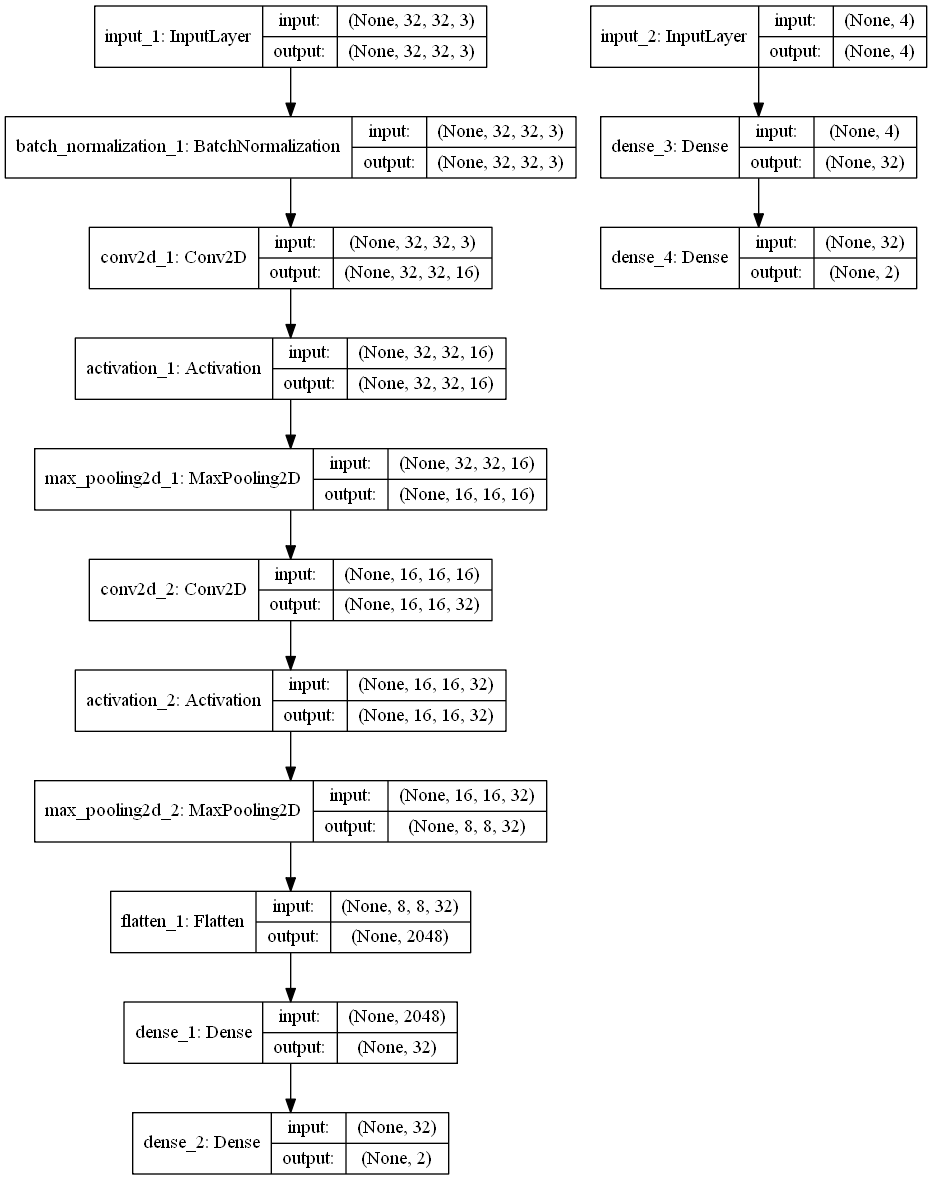

定义loss
* 把loss 定义成一个层 比较有条理
* keras 定义层的方法(两种)
    * 方法1  使用KL.Lambda构建层  func 为函数
      `KL.Lambda(func)(input)`
    * 方法2  继承layer并重写类实现自定义layer
      `import keras.engine as KE`

In [12]:
#定义loss
def custom_loss1(y_true,y_pred):
    return K.mean(K.abs(y_true-y_pred))

In [18]:
# s使用方法1  使用KL.Lambda构建层  func 为函数
loss1=KL.Lambda(lambda x:custom_loss1(*x),name="loss1")([out2,out1])
loss2=KL.Lambda(lambda x:custom_loss1(*x),name="loss2")([input_target,out2])

In [31]:
model=Model([input_tensor1,input_tensor2,input_target],[out1,out2,loss1,loss2])

In [33]:
plot_model(model,to_file="images/model.png",show_shapes=True)

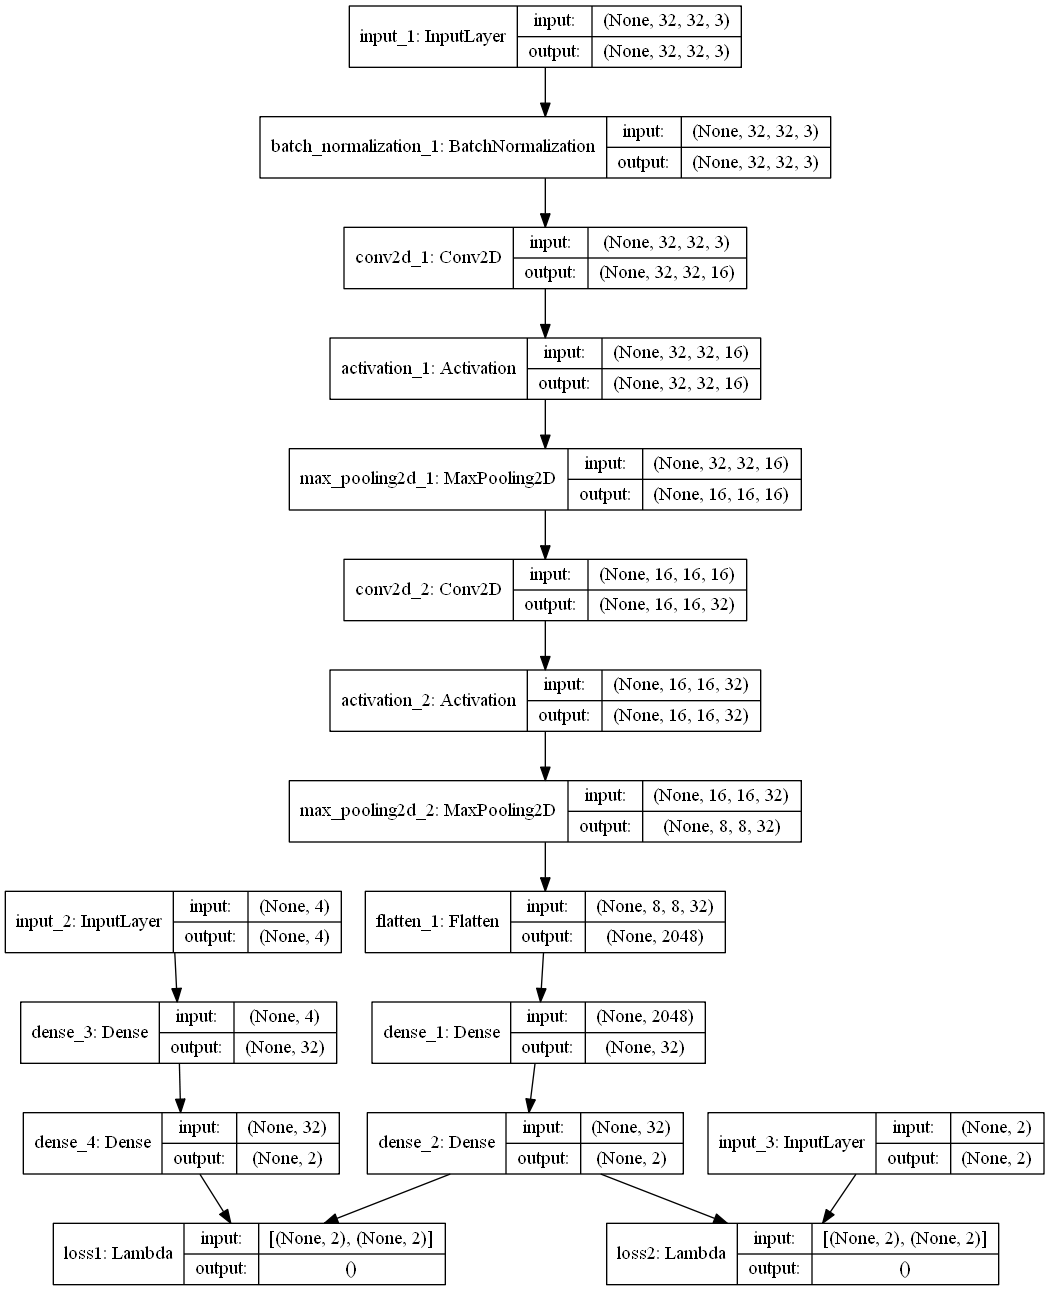

取出loss层`model.get_layer()` 并取出loss层的输出 `model.get_layer(name).output`

In [37]:
loss_layer1=model.get_layer("loss1").output
loss_layer2=model.get_layer("loss2").output
model.add_loss(loss_layer1)
model.add_loss(loss_layer2)
#已经add_loss 过了 所以一下可以设置为None
model.compile(optimizer='sgd',loss=[None,None,None,None])